# Project 2 - Business Statistics: Axis Insurance

    - Consider a significance level of 0.05 (alpha) for all tests.

## Data Dictionary:


   -**Age** : an integer indicating the age of the primary beneficiary (excluding those above 64 years, since they are generally covered by the government.
   
   -**Sex**: policy holder's gender, either male or female. (categorical?)
   
   -**BMI**: Body Mass Index that provides a sense of how over or underweight a person is relative to their height. BMI is equal to weight (kg) divided by height (m) squared (BMI= weight/height^2). **An ideal BMI is within the range of 18.5 to 24.9.**
   
   -**Children**: an integer indicating the number of children/dependents covered by the insurance plan. 
   
   -**Smoker**: yes or no depending on whether the insured regularly smokes tobacco. (categorical?)
   
   -**Region**: the beneficiary's place of residence in the U.S., divided into four geographic regions - northeast, southeast, southwest, or northwest. (categorical?)
   
   -**Charges**: Individual medical costs billed to health insurance.

#### Necessary packages:

In [3]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(color_codes = True)
import warnings
warnings.filterwarnings('ignore')
import copy
from statsmodels.stats.proportion import proportions_ztest 
from statsmodels.formula.api import ols      # for n-way ANOVA
from statsmodels.stats.anova import anova_lm # for n-way ANOVA
from scipy.stats import chi2_contingency  # for Chi-Sq

pd.set_option('display.float_format', lambda x: '%.2f' %x)

#### Read in dataset:

In [4]:
data = pd.read_csv('AxisInsurance.csv')
axis=data.copy() # copying data to avoid any changes to the orig. data

#### View shape and first & last 5 rows of the dataset:

In [5]:
axis.shape

(1338, 7)

Observations:

* 1338 rows and 7 columns.

In [6]:
axis.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.92
1,18,male,33.77,1,no,southeast,1725.55
2,28,male,33.00,3,no,southeast,4449.46
3,33,male,22.70,0,no,northwest,21984.47
4,32,male,28.88,0,no,northwest,3866.86


In [7]:
axis.tail()

,age,sex,bmi,children,smoker,region,charges
1333,50,male,30.97,3,no,northwest,10600.55
1334,18,female,31.92,0,no,northeast,2205.98
1335,18,female,36.85,0,no,southeast,1629.83
1336,21,female,25.80,0,no,southwest,2007.94
1337,61,female,29.07,0,yes,northwest,29141.36


#### Check for missing and duplicated data:

In [8]:
print(axis.isnull().sum())
print('')
print('Any missing data?: ', axis.isnull().values.any())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Any missing data?:  False


In [9]:
dupes = axis.duplicated()
sum(dupes)

1

Observations:
* There is no missing data present.
* There are two data entries that are the same; will not remove as this can be possible for two different individuals.

#### Explore variable data types & convert if necessary:

In [10]:
axis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [11]:
axis.sex = axis.sex.astype('category')
axis.children = axis.children.astype('category')
axis.smoker = axis.smoker.astype('category') 
axis.region = axis.region.astype('category')

In [12]:
axis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1338 non-null   int64   
 1   sex       1338 non-null   category
 2   bmi       1338 non-null   float64 
 3   children  1338 non-null   category
 4   smoker    1338 non-null   category
 5   region    1338 non-null   category
 6   charges   1338 non-null   float64 
dtypes: category(4), float64(2), int64(1)
memory usage: 37.3 KB


Observations:
* All integer variables are valid except for 'children', as it is distinguishing if the insured has children/how many.
* 'sex','region', and 'smoker' are of object data types that are changed to categories in order to reduce the data space required to store the dataframe.
* _Memory usage has decreased by almost half from 73.3+KB to 37.2KB_

#### Statistical summary for the dataset

In [13]:
axis.describe()

,age,bmi,charges
count,1338.00,1338.00,1338.00
mean,39.21,30.66,13270.42
std,14.05,6.10,12110.01
min,18.00,15.96,1121.87
25%,27.00,26.30,4740.29
50%,39.00,30.40,9382.03
75%,51.00,34.69,16639.91
max,64.00,53.13,63770.43


Observations:
* The mean of 'age' & 'BMI' is almost equal to their respective medians, suggesting that there is not much of a skew for either variable.
* The mean of 'charges' is quite off from the median, suggesting that 'charges' is right skewed. The standard deviation is almost as large as the mean and the difference between the minimum and maximum is quite large, also suggesting the right skew.

In [14]:
axis.describe(include=['category'])

,sex,children,smoker,region
count,1338,1338,1338,1338
unique,2,6,2,4
top,male,0,no,southeast
freq,676,574,1064,364


Observations:
* Males (676) hold more insurance policies than females (662), but only by 14.
* Less than half of policy holders (574) have no (0) children/dependents that they claim on their insurance policy, but it has the most amount of policy holders than any other group with dependents. There are 6 different unique answers for this category.
* There are 4 different regions explored, with the region (364) with the most amount of policy holders being in the southeast.

## EDA
### 1. Use Exploratory Data Analysis to explore the dataset and extract insights.

### Univariate analysis:

In [15]:
def histogram_boxplot(feature, figsize=(13,6), bins = None):
    '''Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (default (9,8))
    bins: number of bins (default None/auto)
    '''
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2, 
                                           sharex = True, 
                                           gridspec_kw = {"height_ratios": (.25, .75)}, 
                                           figsize = figsize 
                                           ) 
    sns.boxplot(feature, ax=ax_box2, showmeans=True, color='pink') 
    sns.distplot(feature, kde=F, ax=ax_hist2, bins=bins,palette="pastel") if bins else sns.distplot(feature, kde=False, ax=ax_hist2, color='green')
    ax_hist2.axvline(np.mean(feature), color='red', linestyle='--') 
    ax_hist2.axvline(np.median(feature), color='black', linestyle='-')

#### Age:

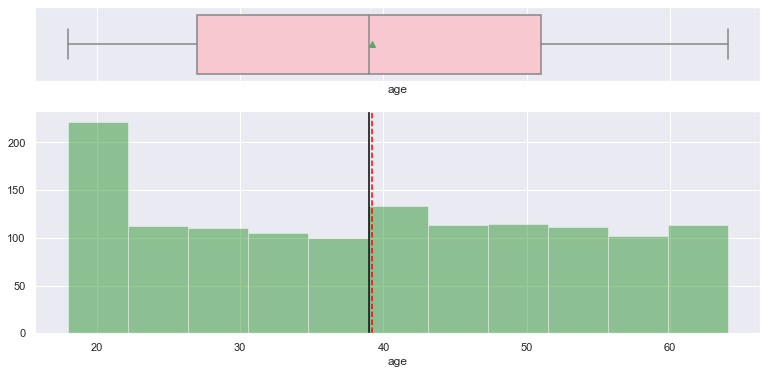

In [16]:
histogram_boxplot(axis['age'])

Observations:
* The mean age of policy holders is around 39 and is almost the same as the median age.
* The age range group with the greatest number of customers is 18-22.

#### BMI:

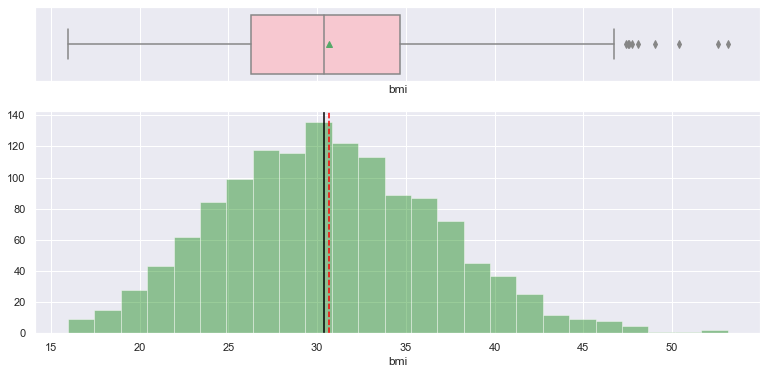

In [17]:
histogram_boxplot(axis['bmi'])

Observations:
* The mean and median are almost the same at around a BMI of around 31.
* There are a few outliers in which a policy holder's BMI is greater than 45.

#### Charges:

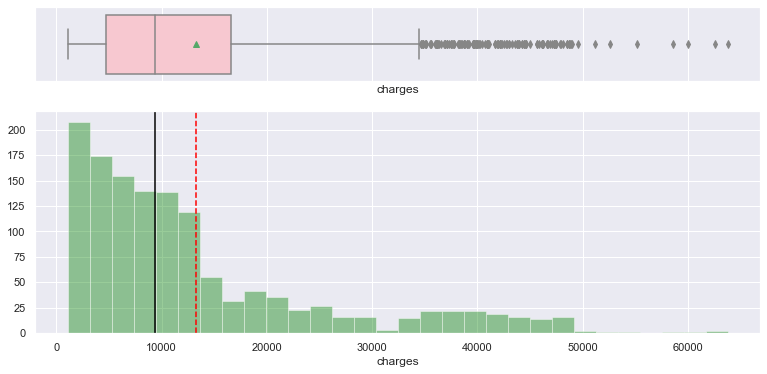

In [357]:
histogram_boxplot(axis['charges'])

Observations:
* The distribution of charges is skewed to the right as the mean is a bit larger than the median.
* There are many outliers.

#### _Categorical:_

In [358]:
# Function to create barplots that indicate percentage for each category.

def perc_on_bar(plot, feature):
    '''
    plot
    feature: categorical feature
    the function won't work if a column is passed in hue parameter
    '''
    total = len(feature) # length of the column
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total) # percentage of each class of the category
        x = p.get_x() + p.get_width() / 2 - 0.05 # width of the plot
        y = p.get_y() + p.get_height()           # hieght of the plot
        ax.annotate(percentage, (x, y), size = 12) # annotate the percantage 
    plt.show() # show the plot

#### Sex:

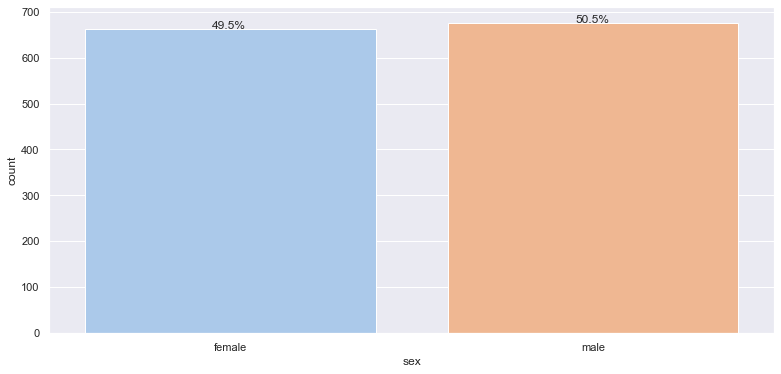

In [359]:
plt.figure(figsize=(13,6))
ax = sns.countplot(axis['sex'],palette='pastel')
perc_on_bar(ax,axis['sex'])

Observations:
* There are more male (50.5%) policy holders than female (49.5%), but only by 1%.

#### Children:

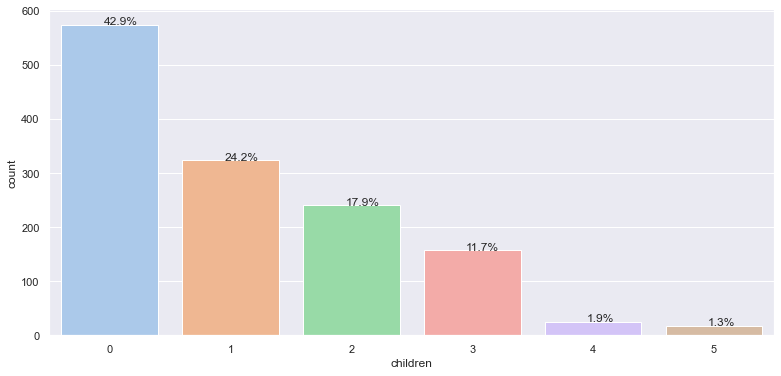

In [360]:
plt.figure(figsize=(13,6))
ax = sns.countplot(axis['children'],palette='pastel')
perc_on_bar(ax,axis['children'])

Observations:
* A significant amount of policy holders have 0 dependents (42.9%)
* As the amount of dependents increases, the number of policy holders decreases.

#### Region:

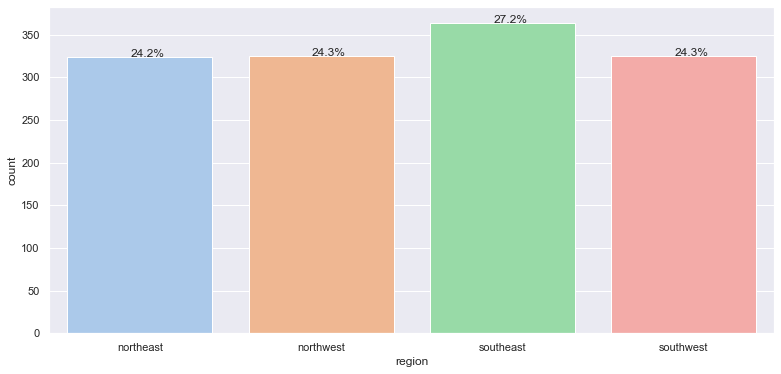

In [361]:
plt.figure(figsize=(13,6))
ax = sns.countplot(axis['region'],palette='pastel')
perc_on_bar(ax,axis['region'])

Observations:
* The southeast region has the most amount of policy holders, but only by a few percent.
* The northwest and southwest both have the same percentage at 24.3%, and the northeast region only 0.1% behind them at 24.2%.

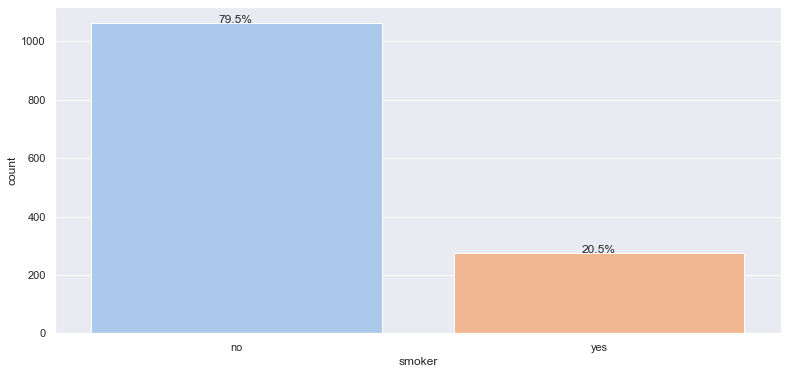

In [639]:
plt.figure(figsize=(13,6))
ax = sns.countplot(axis['smoker'],palette='pastel')
perc_on_bar(ax,axis['smoker'])

Observations:
* There are significantly more non-smokers than there are smokers (59% difference).

### Bivariate Analysis:

In [362]:
axis.corr()

,age,bmi,charges
age,1.00,0.11,0.30
bmi,0.11,1.00,0.20
charges,0.30,0.20,1.00


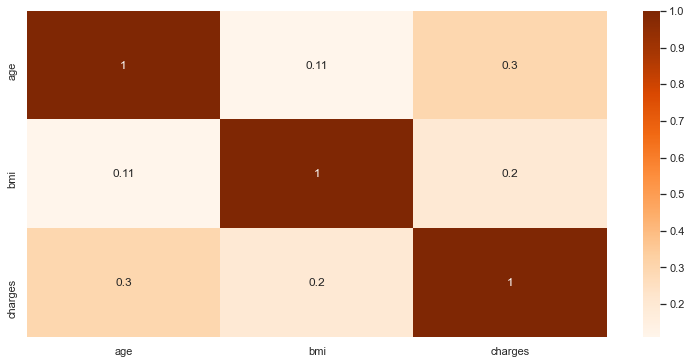

In [641]:
plt.figure(figsize=(13,6))
sns.heatmap(axis.corr(), annot=True, cmap='Oranges');

Observations:
* Observed variables have low correlation between each other.
* Charges and age have the greatest correlation out of the observed variables.

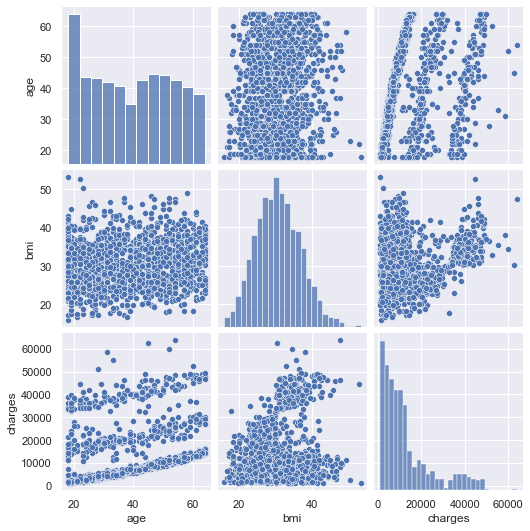

In [644]:
sns.pairplot(axis, palette='Oranges'); # Color scheme did not change?
plt.show()

#### Sex vs Age:

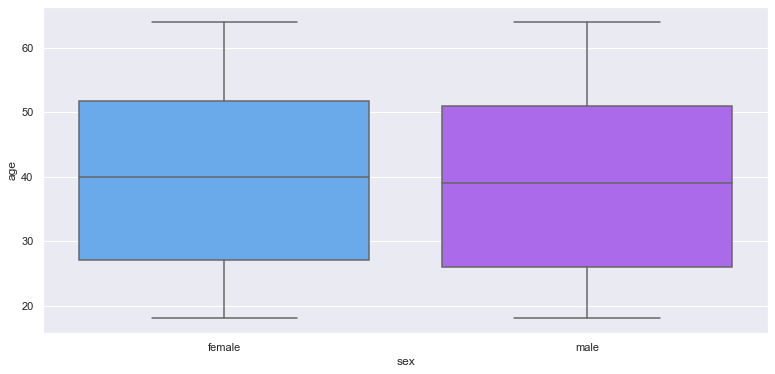

In [643]:
plt.figure(figsize=(13,6))
sns.boxplot(axis['sex'], axis['age'], palette='cool')
plt.show()

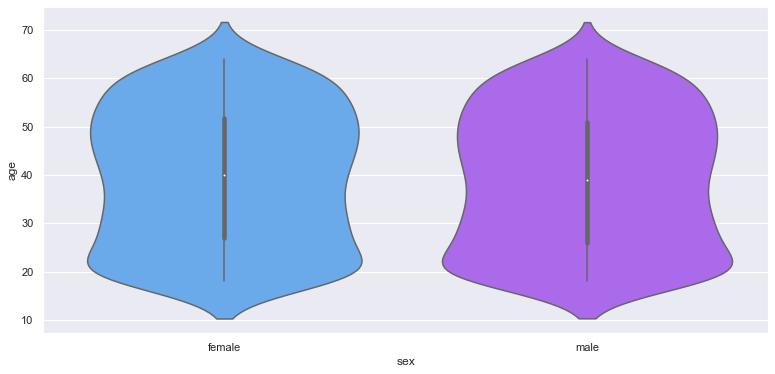

In [366]:
plt.figure(figsize=(13,6))
ax = sns.violinplot(x='sex', y='age', data=axis, palette='cool')

Observations:
* There is not a significant difference between the ages of males and females.
* Men seem to have policies at a little bit of a younger age than women with a mean age of ~39 while women tend to hold onto their policies a little bit longer than men and have a mean age of ~40. 

#### Sex vs BMI:

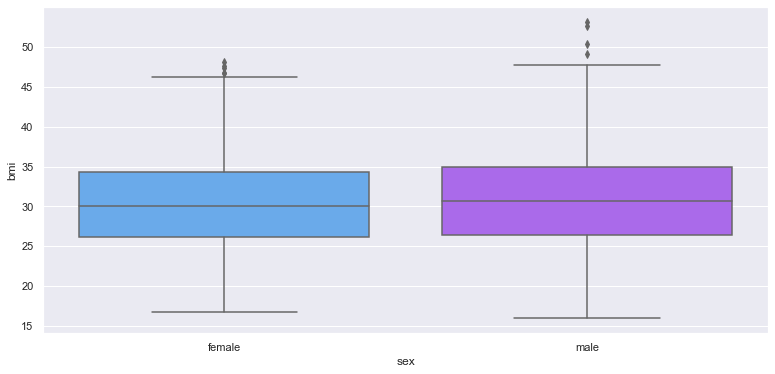

In [367]:
plt.figure(figsize=(13,6))
sns.boxplot(axis['sex'], axis['bmi'], palette='cool')
plt.show()

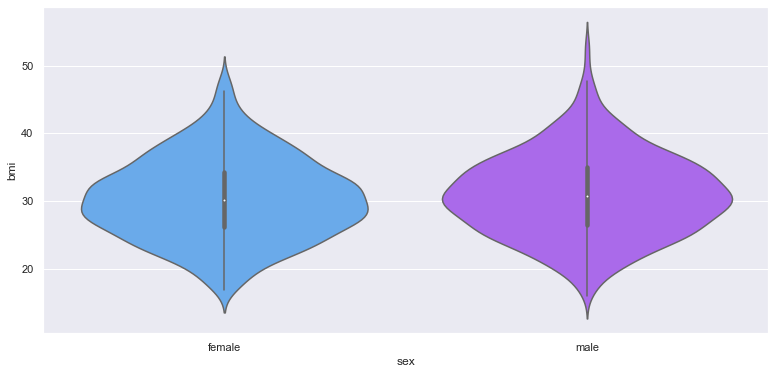

In [368]:
plt.figure(figsize=(13,6))
ax = sns.violinplot(x='sex', y='bmi', data=axis, palette='cool')

Observations:
* Men tend to have a slightly greater BMI than females with a mean of about 31.
* Women tend to be in a little bit better shape than males with a mean BMI of just above 30.

#### Sex vs Charges:

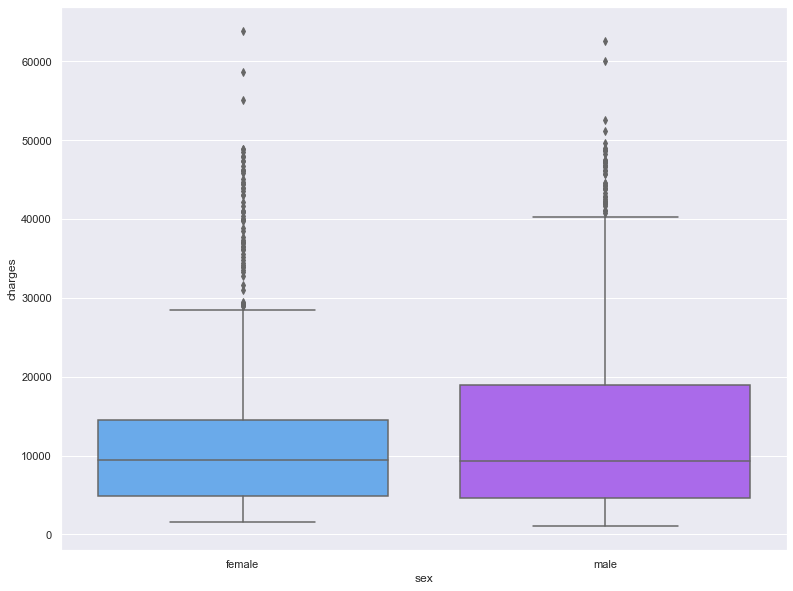

In [369]:
plt.figure(figsize=(13,10))
sns.boxplot(axis['sex'], axis['charges'], palette='cool')
plt.show()

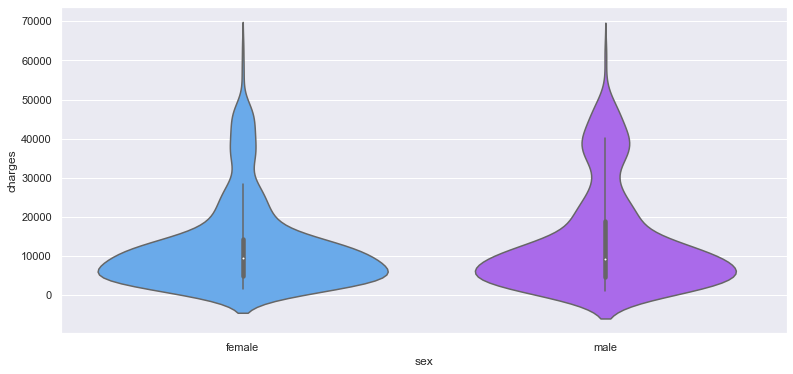

In [370]:
plt.figure(figsize=(13,6))
ax = sns.violinplot(x='sex', y='charges', data=axis, palette='cool')

Observations:
* Although the mean between the charges for female and males are quite close together, women seem to have a greater deal of outliers.
* Women's third quartile (Q3) is less than men's third quartile, at about 15k and 19k respectively. 

#### Sex vs Children:

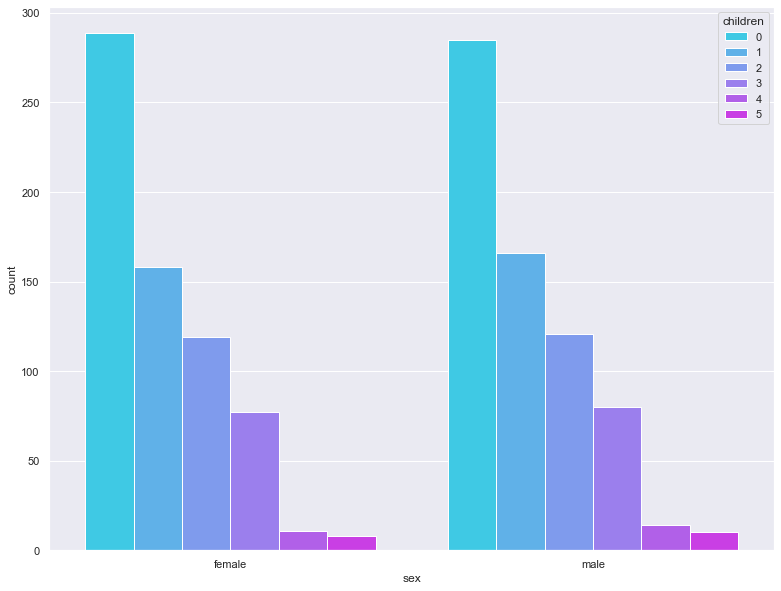

In [371]:
plt.figure(figsize=(13,10))
sns.countplot(axis['sex'], hue=axis['children'], palette='cool')
plt.show()

Observations:
* The numbers are fairly even between females and males when it comes to number of children/dependents they have.

#### Sex vs Smoker:

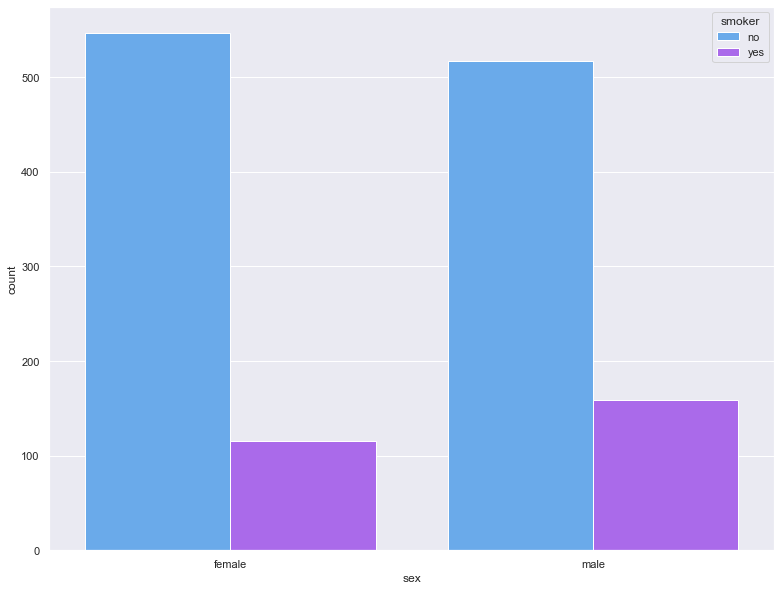

In [483]:
plt.figure(figsize=(13,10))
sns.countplot(axis['sex'], hue=axis['smoker'], palette='cool')
plt.show()

Observations:
* There are more female non-smokers than males.

#### Sex vs Region:

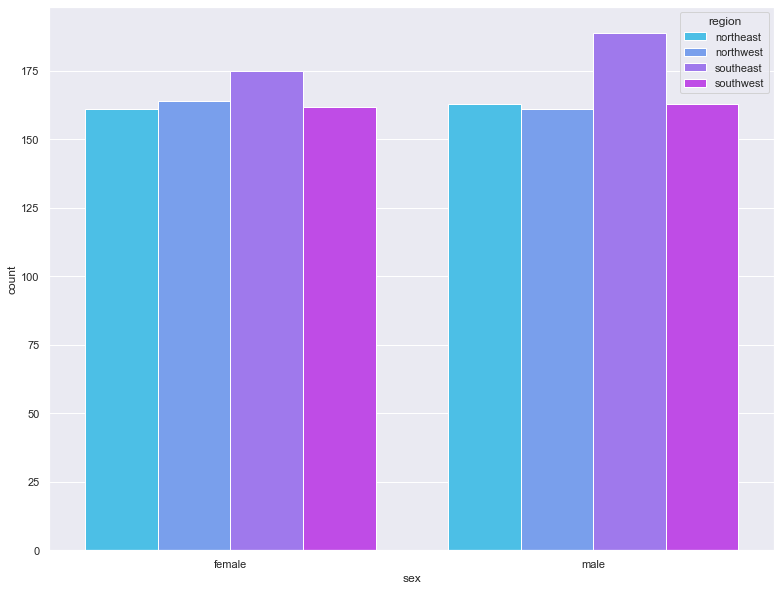

In [373]:
plt.figure(figsize=(13,10))
sns.countplot(axis['sex'], hue=axis['region'], palette='cool')
plt.show()

Observations:
* While number of females in the northeast, northwest, and southwest and pretty similar between men and women, there is a significantly greater number of men in the southeast region with an insurance policy through Axis.

#### Smoker vs Age:

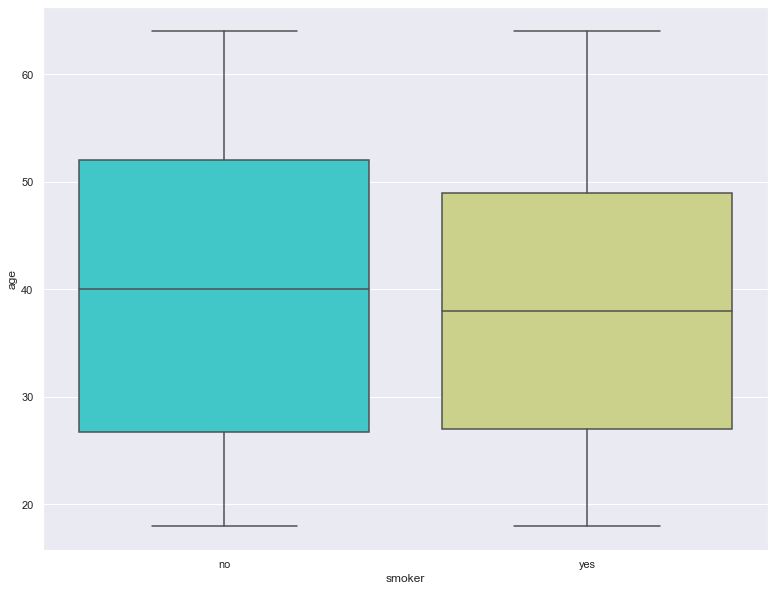

In [374]:
plt.figure(figsize=(13,10))
sns.boxplot(axis['smoker'], axis['age'], palette='rainbow')
plt.show()

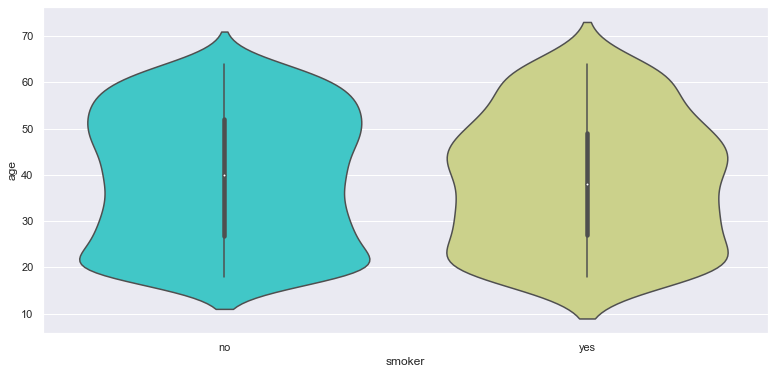

In [375]:
plt.figure(figsize=(13,6))
ax = sns.violinplot(x='smoker', y='age', data=axis, palette='rainbow')

Observations:
* Policy holders that smoke tend to be between the ages of ~28-49.

#### Smoker vs BMI:

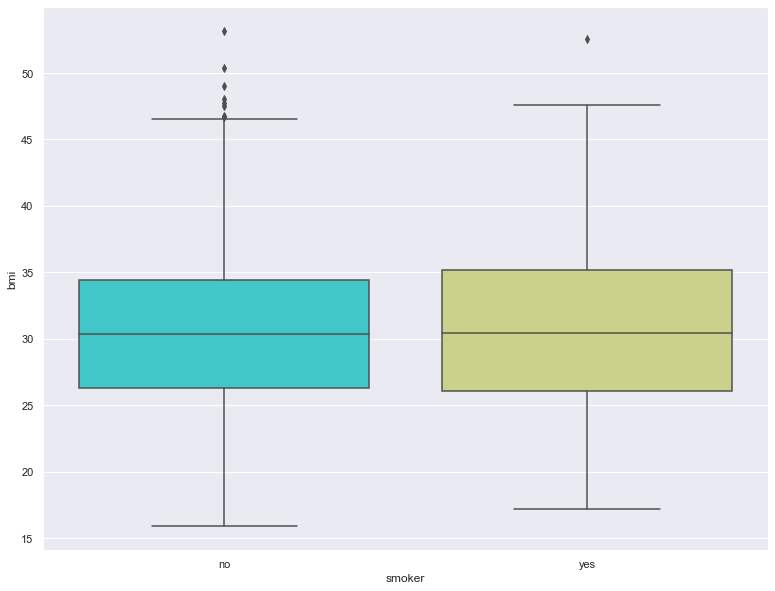

In [376]:
plt.figure(figsize=(13,10))
sns.boxplot(axis['smoker'], axis['bmi'], palette='rainbow')
plt.show()

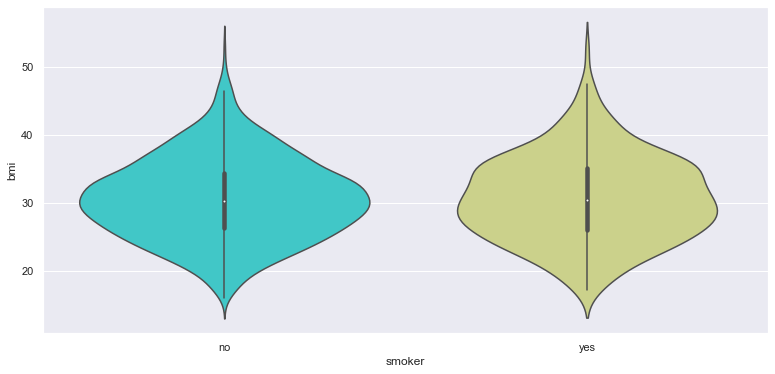

In [377]:
plt.figure(figsize=(13,6))
ax = sns.violinplot(x='smoker', y='bmi', data=axis, palette='rainbow')

Observations:
* The median BMI for smokers and non-smokers is almost identical, although non-smokers have a lower upper and lower limit than smokers do.
* The non-smokers category has a handful of outliers, potentially skewing the median to the right (or in this case, upwards).

#### Smoker vs Children:

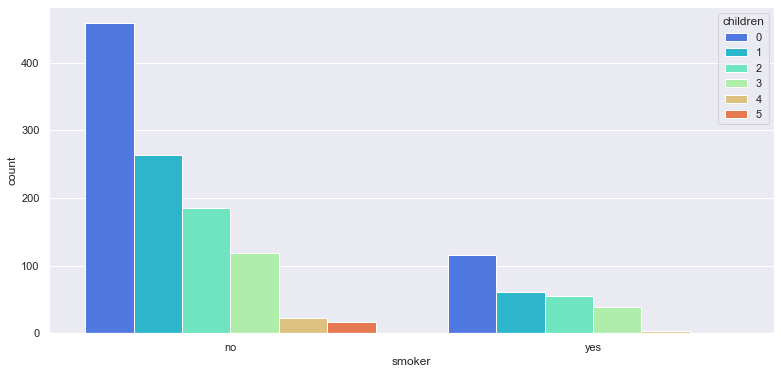

In [378]:
plt.figure(figsize=(13,6))
sns.countplot(axis['smoker'], hue=axis['children'], palette='rainbow')
plt.show()

Observations:
* For both non-smokers and smokers, the amount of policy holders goes down while the number of children/dependents goes up. 

#### Smoker vs Region:

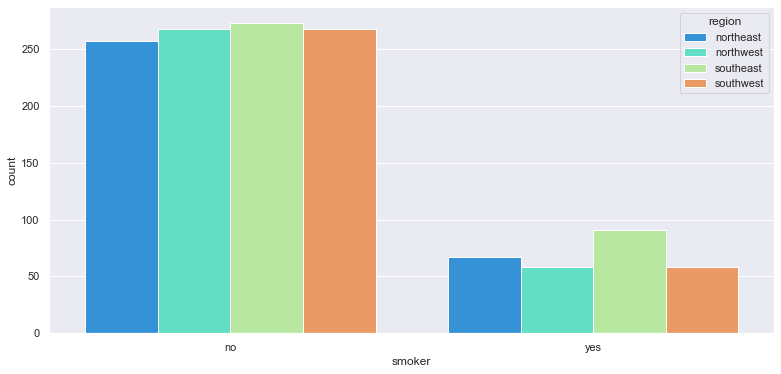

In [379]:
plt.figure(figsize=(13,6))
sns.countplot(axis['smoker'], hue=axis['region'], palette='rainbow')
plt.show()

Observations:
* For both non-smokers and smokers, the southeast has the greatest amount, but the southeast also has the greatest amount of policy holders than any other region.

#### Smoker vs Charges:

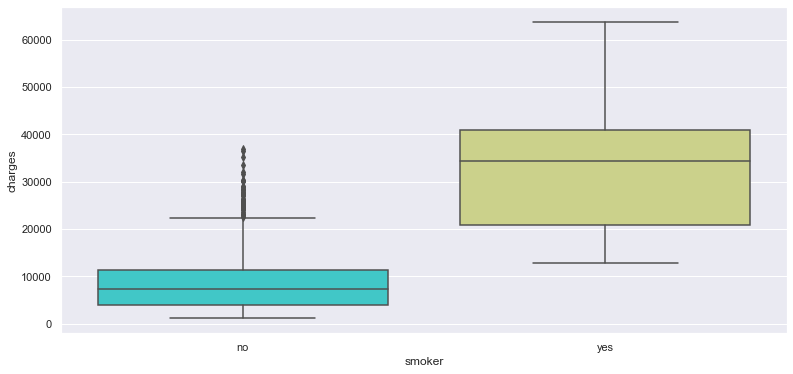

In [380]:
plt.figure(figsize=(13,6))
sns.boxplot(axis['smoker'], axis['charges'], palette='rainbow')
plt.show()

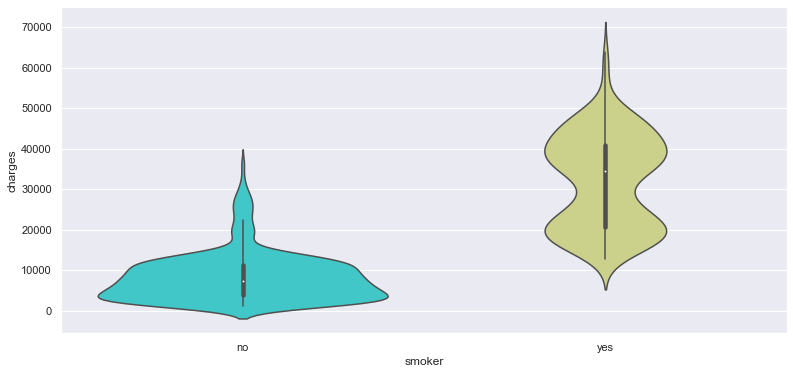

In [381]:
plt.figure(figsize=(13,6))
ax = sns.violinplot(x='smoker', y='charges', data=axis, palette='rainbow')

Observations:
* The amount of charges that 75% of non-smokers have is less than the lower limit of charges for smokers.
* Non-smokers have quite a bit of outliers for charges.

#### Children vs Age:

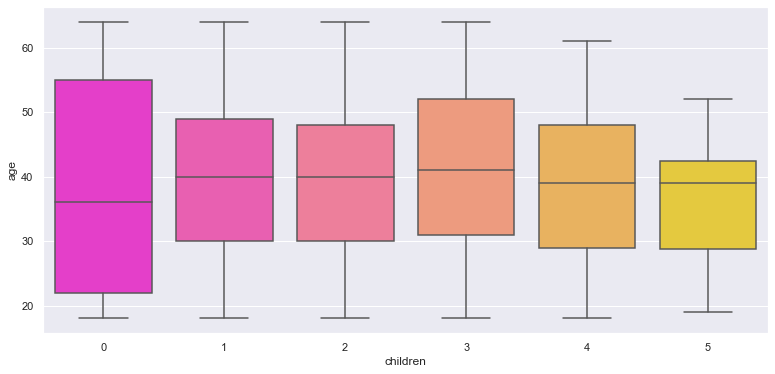

In [382]:
plt.figure(figsize=(13,6))
sns.boxplot(axis['children'], axis['age'], palette='spring')
plt.show()

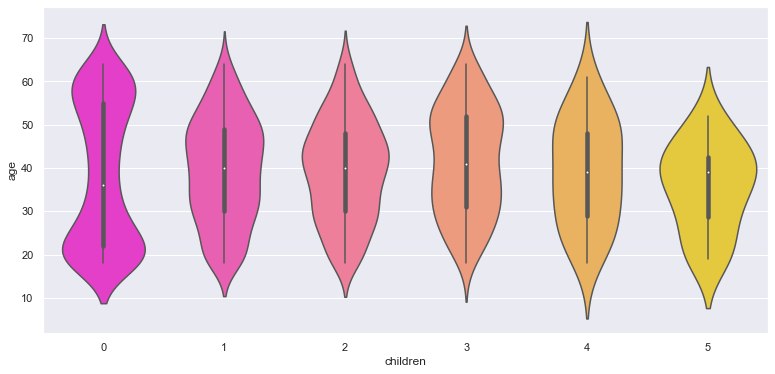

In [383]:
plt.figure(figsize=(13,6))
ax = sns.violinplot(x='children', y='age', data=axis, palette='spring')

Observations:
* A majority of policy holders with at least 1 kid are between the ages of 30 and 50.
* The medians for people with 1, 2, 3, 4, and 5 children are very close.

#### Children vs BMI:

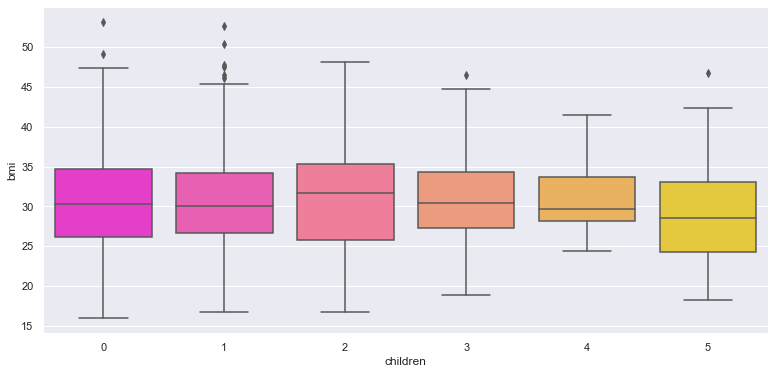

In [384]:
plt.figure(figsize=(13,6))
sns.boxplot(axis['children'], axis['bmi'], palette='spring')
plt.show()

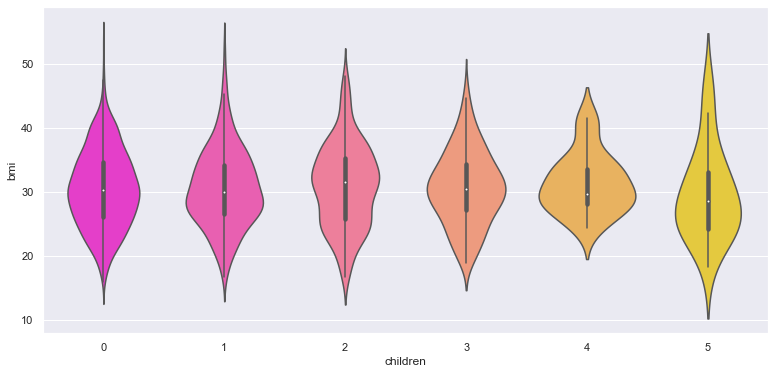

In [385]:
plt.figure(figsize=(13,6))
ax = sns.violinplot(x='children', y='bmi', data=axis, palette='spring')

Observations:
* The median BMI of those with 5 children is the lowest.
* Excluding those with 2 children, a majority of those with 0, 1, 3, 4, and 5 children have BMIs less than 35.

#### Children vs Region:

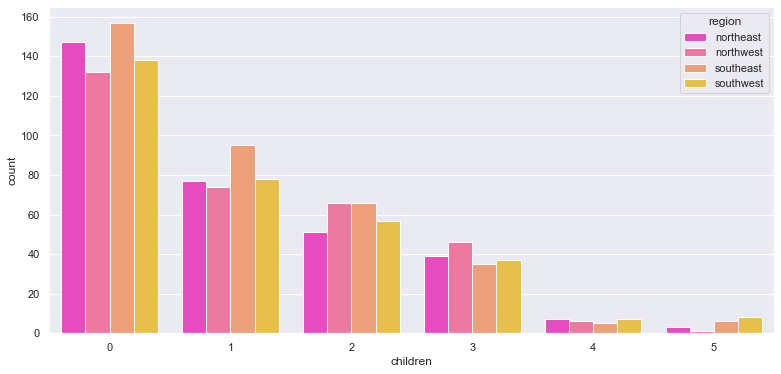

In [386]:
plt.figure(figsize=(13,6))
sns.countplot(axis['children'], hue=axis['region'], palette='spring')
plt.show()

Observations:
* For every region, policy holders with 0 children is the largest group.

#### Children vs Charges:

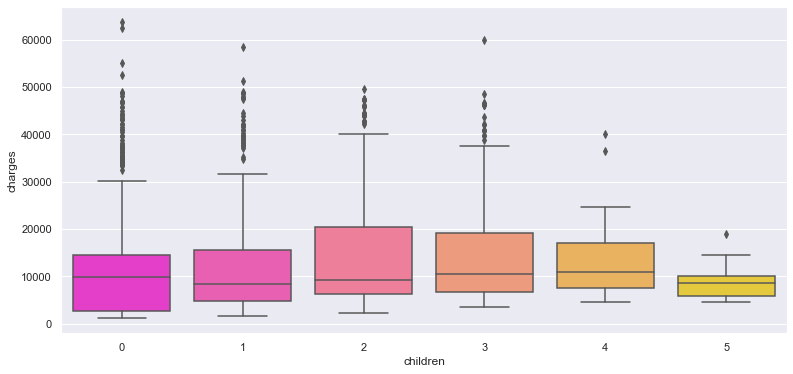

In [387]:
plt.figure(figsize=(13,6))
sns.boxplot(axis['children'], axis['charges'], palette="spring")
plt.show()

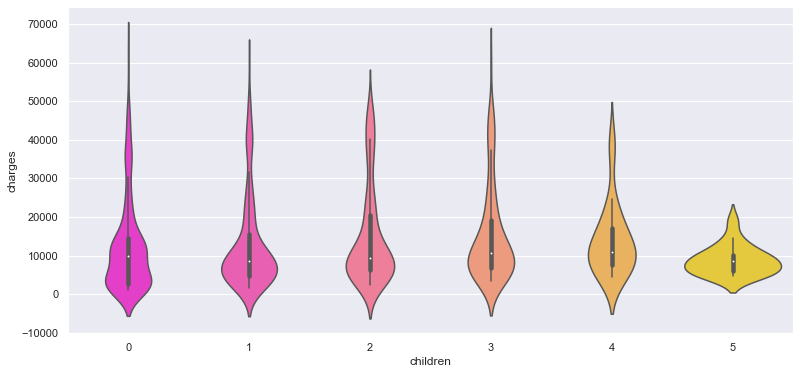

In [388]:
plt.figure(figsize=(13,6))
ax = sns.violinplot(x='children', y='charges', data=axis, palette='spring')

Observations:
* While the lower limit and Q1 for charges for policy holders with 0 children is the lowest, it also has the greatest amount and span of outliers. The median for 0 children is also higher than the median for 1 child, 2 children and 5 children, but that may be because it is skewed due to all the outliers.
* Each group also has outliers, potentially skewing the median.
* Charges for policy holders with 2 children have a greater Q3 and upper limit than all other groups with (or without) children.

#### Region vs Age

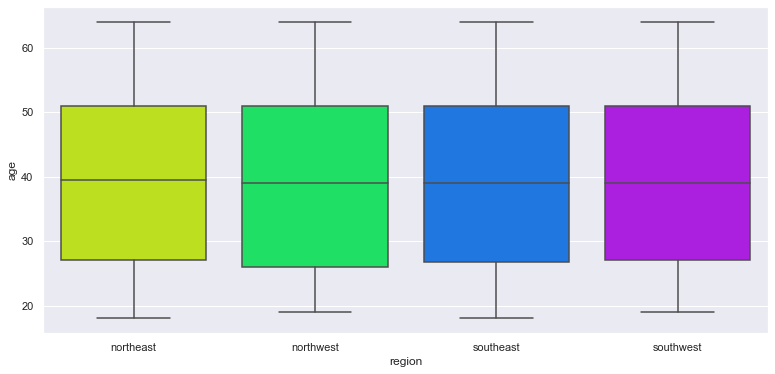

In [389]:
plt.figure(figsize=(13,6))
sns.boxplot(axis['region'], axis['age'], palette='hsv')
plt.show()

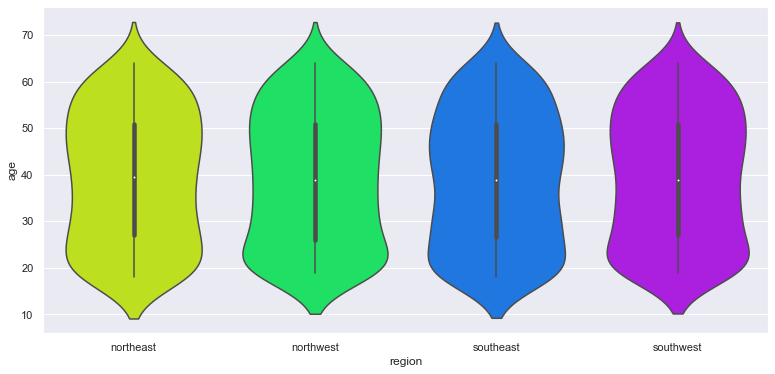

In [390]:
plt.figure(figsize=(13,6))
ax = sns.violinplot(x='region', y='age', data=axis, palette='hsv')

Observations:
* The median age is almost the same for all regions along with the Q3s and upper limits being very close as well.

#### Region vs BMI:

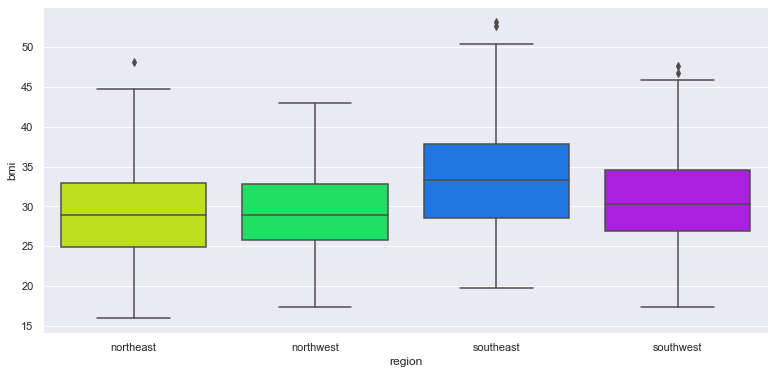

In [391]:
plt.figure(figsize=(13,6))
sns.boxplot(axis['region'], axis['bmi'], palette='hsv')
plt.show()

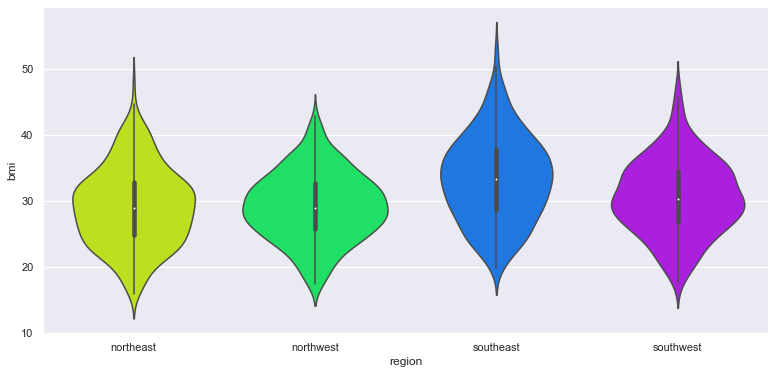

In [392]:
plt.figure(figsize=(13,6))
ax = sns.violinplot(x='region', y='bmi', data=axis, palette='hsv')

Observations:
* The BMI for the southeast region far exceeds the BMIs for the other regions. The Q1, median, Q3, and lower and upper limit for the southeast region is greater than the other regions respective quartiles/whiskers.
* The median for the northeast and northwest look to be identical, but the northwest has a greater lower limit and Q1 while having a lower Q3 and upper limit than the northeast region.

#### Region vs Charges:

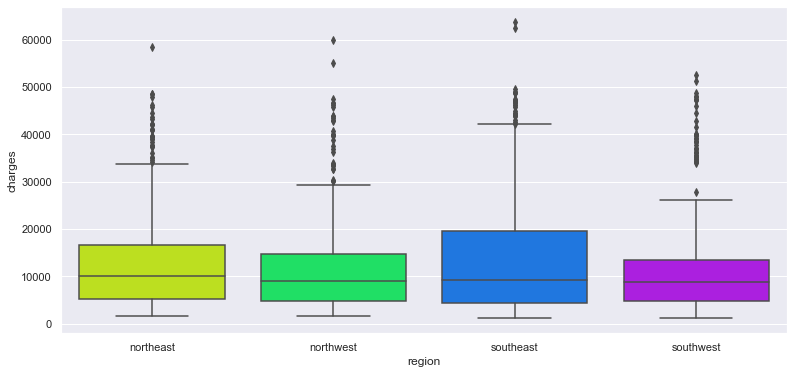

In [393]:
plt.figure(figsize=(13,6))
sns.boxplot(axis['region'], axis['charges'], palette='hsv')
plt.show()

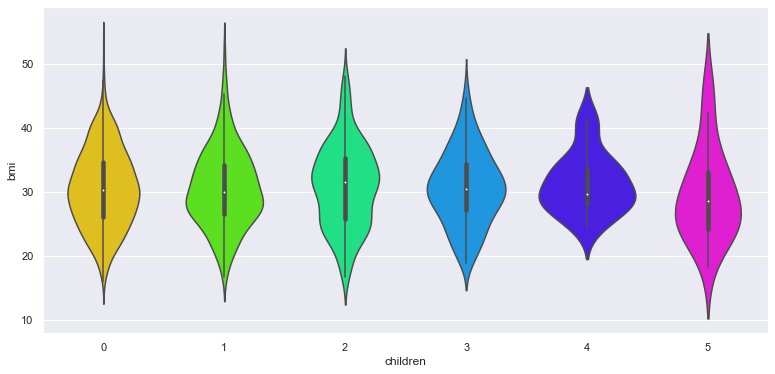

In [394]:
plt.figure(figsize=(13,6))
ax = sns.violinplot(x='children', y='bmi', data=axis, palette='hsv')

Observations:
* Each region has outliers.
* The southeast region has the biggest range (lowest Q1 and greatest Q3) in charges along with the most amount of an outlier, which is 61k+.
* The median charge for the northwest, southeast, and southwest region are almost identical. The median charge for the northeast region is only ~1k more than the other regions.

### Grouping data with respect to (w.r.t.) sex to build customer profiles:

In [395]:
# axis[axis['sex']=='female'].describe(include='all')

In [396]:
# axis[axis['sex']=='male'].describe(include='all')

### Multivariate Analysis:

#### Charges vs Age vs Smoker:

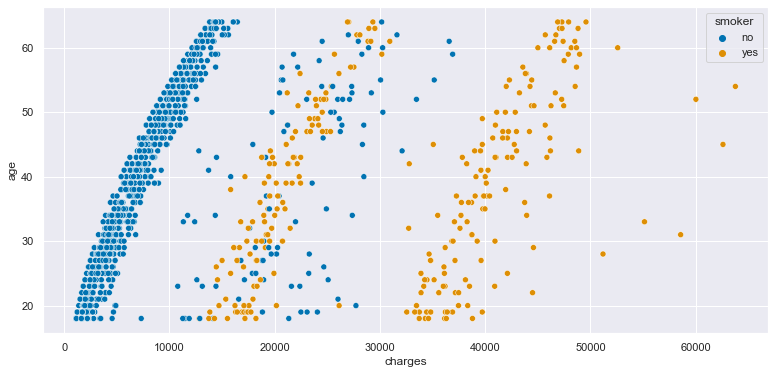

In [397]:
plt.figure(figsize=(13,6))
sns.scatterplot(axis['charges'], axis['age'], hue=axis['smoker'], ci=0, palette = 'colorblind')
plt.show()

Observations:
* The charges non-smokers are mostly between ~1k-16k and the amount of the charges increases by age. There are several dozen outliers up until the amount of ~37k.
* For smokers, the data is alot less uniformed. From the amounts of ~14k-30k & ~33k-49k the charges a policy holder makes also increases with age. 
* There are no smokers that have less than 13k in charges and there are several outliers past 50k.
* It is obvious that for the most part, non-smokers charge less than smokers.

#### BMI vs Charges vs Sex:

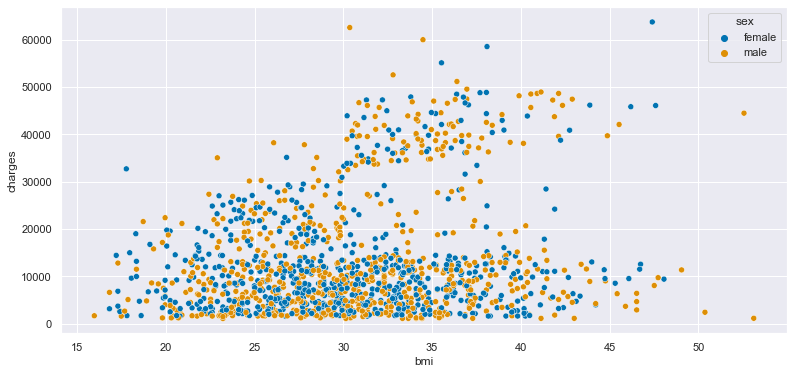

In [398]:
plt.figure(figsize=(13,6))
sns.scatterplot(axis['bmi'], axis['charges'], hue=axis['sex'], ci=0, palette = 'colorblind')
plt.show()

Observations:
* There does not appear to be much of a pattern between the BMI and sex of a policy holder and their respective policy charge, except that it looks like men between the BMI range of 20-36 have a mostly smaller lower limit charge than women in for that BMI range.

#### Age vs Charges vs Region:

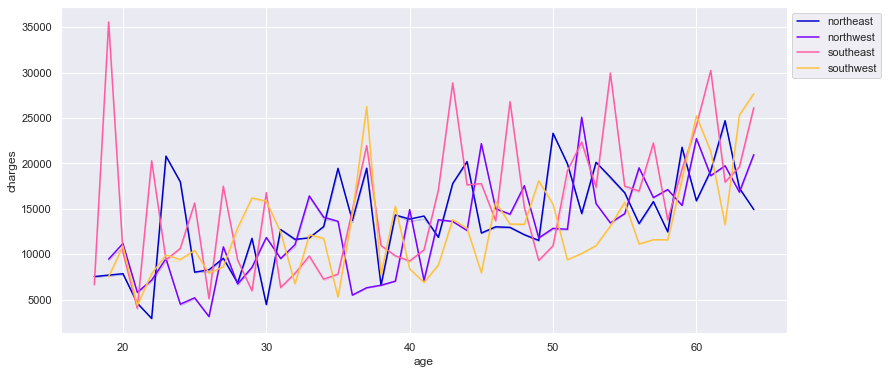

In [399]:
plt.figure(figsize=(13,6))
sns.lineplot(axis['age'],axis['charges'],hue=axis['region'],ci=0, palette = 'gnuplot2')
plt.legend(bbox_to_anchor=(1.00, 1))
plt.show()

Observations:
* From the age of 18-20 there is an extreme rise and fall for charges for the southeast region.
* From the ages 40-60+ the southeast region periodically has 4 major spikes.
* The northwest region also has several major rises and falls from mid 30s-50s, but not as extreme as the southeast region.

#### Age vs Charges vs Sex:

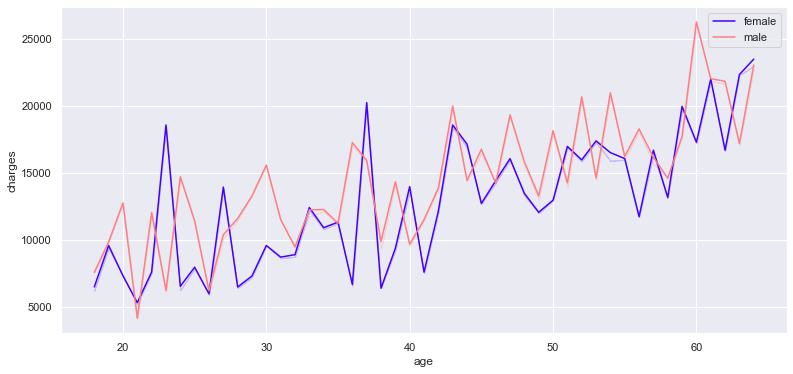

In [400]:
plt.figure(figsize=(13,6))
sns.lineplot(axis['age'],axis['charges'],hue=axis['sex'],ci=0, palette = 'gnuplot2')
plt.legend(bbox_to_anchor=(1.00, 1))
plt.show()

Observations:
* Women appear to have larger spikes in charges than men, especially from the ages of ~22-24, ~36-38.
* Overall it appears that at almost any given age, males tend have larger claims than females.

#### Age vs BMI vs Sex:

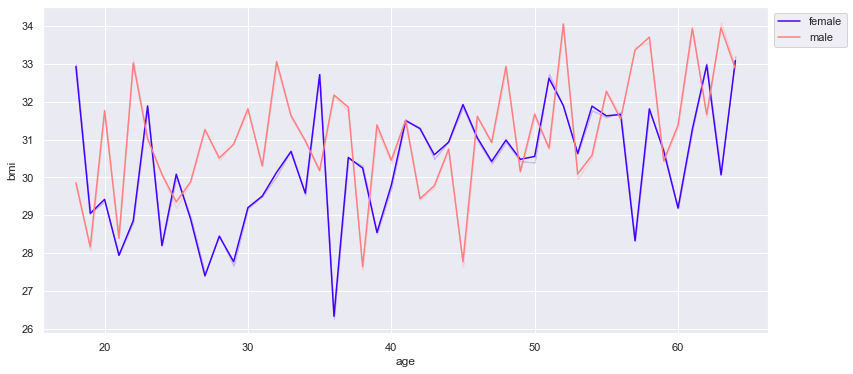

In [401]:
plt.figure(figsize=(13,6))
sns.lineplot(axis['age'],axis['bmi'],hue=axis['sex'],ci=0, palette = 'gnuplot2')
plt.legend(bbox_to_anchor=(1.00, 1))
plt.show()

Observations:
* Between the ages of 25 and 31 the BMI trend for men and women seem to mirror each other. (From the ages of ~25-27 women's BMI drops drastically, then starts to go up again until it drops at 28 and then continues to rise after that. For men, it does almost the exact opposite, where bmi rises, then falls, then rises until the age of 30 then drops again from 30-31.)
* From the age of 18 to 19 the BMI for females drops drastically.
* Females appear to have, mostly, larger spikes in BMI than males.

#### Region vs BMI vs Sex:

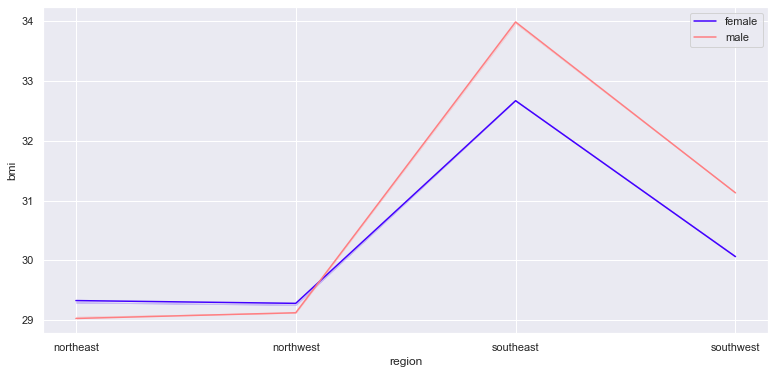

In [402]:
plt.figure(figsize=(13,6))
sns.lineplot(axis['region'], axis['bmi'], hue=axis['sex'], ci=0, palette='gnuplot2')
plt.legend(bbox_to_anchor=(1.00, 1))
plt.show()

Observations:
* In the north, a majority of females tend to have a slightly higher BMI than the majority of men males, while in the south the majority of males tend to have a higher BMI than a majority females.
* In the northern regions a majority of both men and women typically have BMIs less than 30, while in the southern regions they are greater than 30.
* The southeast region has the greatest BMI for both men and women. 

#### Children vs Age vs Region

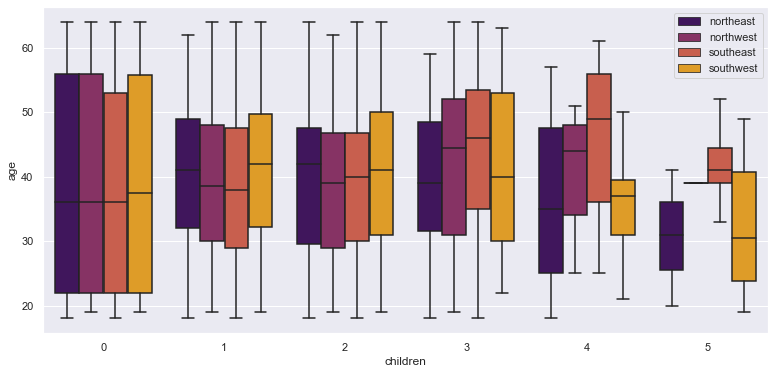

In [403]:
plt.figure(figsize=(13,6))
sns.boxplot(axis['children'], axis['age'], hue=axis['region'], palette='inferno')
plt.legend(bbox_to_anchor=(1.00,1))
plt.show()

Observations:
* Regardless of the region or age, most policy holders have 0 children/dependents.
* The median age of policy holders with 0 children for the northeast, northwest, and southwest are the exact same.
* There appears to be extremely few policy holders from the northwest that have 5 children/dependents.

#### Children vs BMI vs Sex:

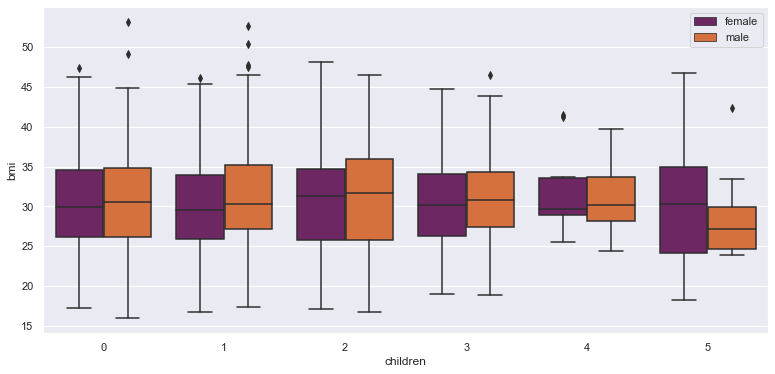

In [404]:
plt.figure(figsize=(13,6))
sns.boxplot(axis['children'], axis['bmi'], hue=axis['sex'], palette='inferno')
plt.legend(bbox_to_anchor=(1.00,1))
plt.show()

Observations:
* The median BMI for women is lower than the median BMI for men for all amounts of children, except for policy holders with 5 children. Also, most of the median BMIs for men and women are relatively close to each other except for men and women with 5 dependents.
* The upper limit for women with 4 children is almost the same as the 3rd quartile for that group. 

#### Smoker vs BMI vs Sex:

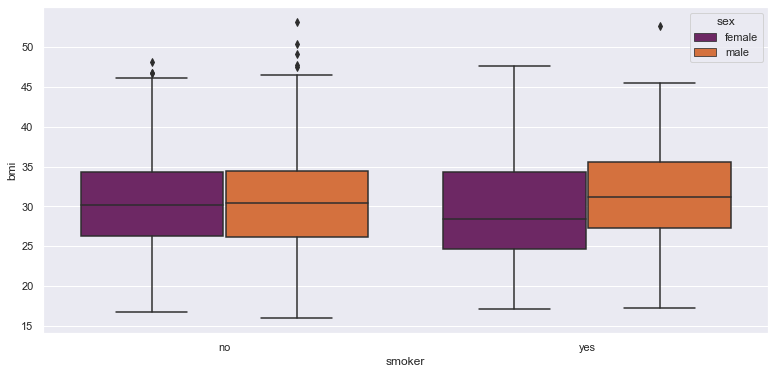

In [405]:
plt.figure(figsize=(13,6))
sns.boxplot(axis['smoker'], axis['bmi'], hue=axis['sex'], palette = 'inferno')
plt.show()

Observations:
* There are more outliers for the BMIs of both female and males for non-smokers
* While the median BMI for women is higher in non-smokers than smokers, it is vice versa for men, with the smoker having a higher BMI than the non-smoker.
* The Q3 BMI for female smokers and non-smokers is virtually the same.

#### Children vs Charges vs Sex: 

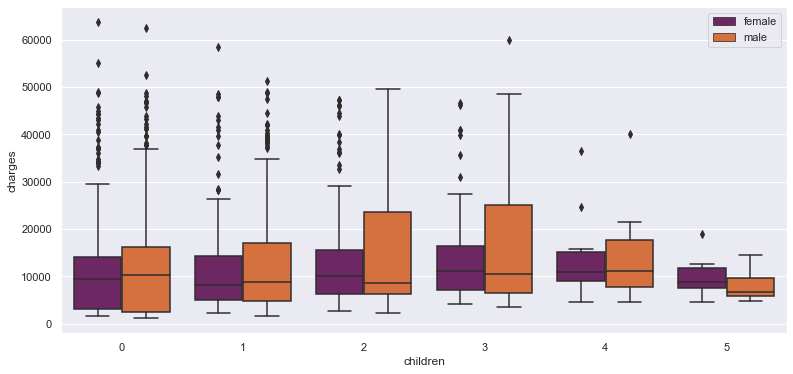

In [406]:
plt.figure(figsize=(13,6))
sns.boxplot(axis['children'], axis['charges'], hue=axis['sex'], palette='inferno')
plt.legend(bbox_to_anchor=(1.00,1))
plt.show()

Observations:
* Almost every group has outliers, with an extreme out of outliers in the groups with 0-2 children.
* The median charges for men and women with 4 children is the same.
* For each amount of children, the upper limit for females is lower than the upper limit for men. 

## Hypothesis Testing
### 2. Prove or disprove: medical claims made by the people who smoke is greater than those who don't smoke.

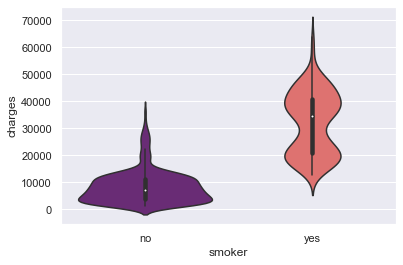

In [493]:
ax = sns.violinplot(x='smoker', y='charges', data=axis, palette='magma') # from bivariate analysis above

In [422]:
axis.groupby('smoker')['charges'].mean()

smoker
no     8434.27
yes   32050.23
Name: charges, dtype: float64

__Step 1: Define the null hypothesis (H<sub>0</sub>) and the alternative hypothesis (H<sub>A</sub>)__

Hypothesis: people who smoke have a greater amount of medical claims than people who do not smoke.

#### H<sub>0</sub>: µ<sub>smoker</sub> ≤ µ<sub>non</sub> 
* people who smoke have less than or the same amount in medical claims as those who do not smoke.


#### H<sub>A</sub>: µ<sub>smoker</sub> > µ<sub>non</sub>
* people who smoke have a greater amount in medical claims than those who do not smoke. and people who don't smoke have a greater in medical claims.

__Step 2: Decide the significance level__

* α = 0.05

__Step 3: Identify the test__
* This is a two-sample, independent t-test (one-tailed)

__Step 4: Calculate the test-statistics & p-value__

In [482]:
x0 = np.array(axis[axis.smoker=='no'].charges)
x1 = np.array(axis[axis.smoker=='yes'].charges)

t, p_twotailed = stats.ttest_ind(x0, x1)
print('tstat =',t,'\np_twotailed =', p_twotailed,'\np_onetailed =', p_twotailed/2)

tstat = -46.664921172723716 
p_twotailed = 8.271435842177219e-283 
p_onetailed = 4.1357179210886093e-283


__Step 5: Decide to reject or to accept the null hypthesis__

Since P-value (4.1357e-283) < α (0.05) we __reject the null hypothesis (H<sub>0</sub>)__ and come to the conclusion that those who smoke have medical claims that are greater than those who do not smoke.


### 3. Prove or disprove: with statistical evidence that the BMI of females is different from that of males.

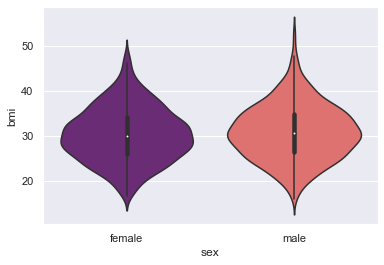

In [494]:
ax = sns.violinplot(x='sex', y='bmi', data=axis, palette='magma')

In [496]:
axis.groupby('sex')['bmi'].mean()

sex
female   30.38
male     30.94
Name: bmi, dtype: float64

__Step 1:__ Hypothesis: The BMI of females is different than the BMI of males (the sex of an individual has an influence on their BMI).

  (H<sub>0</sub>: BMI<sub>f</sub> = BMI<sub>m</sub> & H<sub>A</sub>: BMI<sub>f</sub> != BMI<sub>m</sub>)
    
#### H<sub>0</sub>: µ<sub>f</sub> = µ<sub>m</sub> 
* The BMI of females is equal to the BMI of males & the sex of an individual does not have influence on their BMI.

    
#### H<sub>A</sub>: µ<sub>f</sub> != µ<sub>m</sub> 
* The BMI of females is not equal to that of males & the sex of an individual does have influence on their BMI.

__Step 2:__ α = 0.05


__Step 3:__ two-sample, independent t-test (two-tailed)


__Step 4:__

In [508]:
f = np.array(axis[axis.sex=='female'].bmi)
m = np.array(axis[axis.sex=='male'].bmi)

t, p_twotailed = stats.ttest_ind(m, f)
print('tstat =',t,'\np_twotailed =', p_twotailed)

tstat = 1.696752635752224 
p_twotailed = 0.08997637178984932


__Step 5:__

Since P-value (0.08998) > α (.05) we __fail to reject the null hypothesis (H<sub>0</sub>)__ and conclude that the sex of an individual does not have influence on their BMI.


*from mentor session* P is given the nullhypothesis is true



### 4. Is the proportion of smokers significantly different across different regions?

__Step 1:__
Hypothesis: The proportion of smokers is different across different regions.

#### H<sub>0</sub>: R<sub>NE</sub> = R<sub>NW</sub> = R<sub>SE</sub> = R<sub>SW</sub> 
* Region does not play a significant role on smoking habits. 


#### H<sub>A</sub>: R<sub>NE</sub> != R<sub>NW</sub> != R<sub>SE</sub> != R<sub>SW</sub> 
* Region does have play a significant role on smoking habits.

__Step 2:__

* α = 0.05

__Step 3:__
* Chi-Sq test (categorical data is in raw frequencies)

__Step 4:__

In [521]:
df = pd.crosstab(axis['region'], axis['smoker'], margins = False)
df 

smoker,no,yes
region,,
northeast,257,67
northwest,267,58
southeast,273,91
southwest,267,58


In [524]:
chi2, pval, dof, exp_freq = chi2_contingency(df, correction = False)

In [525]:
exp_freq

array([[257.65022422,  66.34977578],
       [258.44544096,  66.55455904],
       [289.45889387,  74.54110613],
       [258.44544096,  66.55455904]])

In [526]:
pval

0.06171954839170541

__Step 5:__

Since P-value (0.0617) > α (.05) we __fail to reject the null hypothesis (H<sub>0</sub>)__ which implies that there is not a significant difference in the proportion of smokers across different regions. Therefore, region does not play a notable role on an individual's smoking habits.

### 5. Is the mean BMI of women with no children, one child, & two children the same? Explain your answer with statistical evidence.

In [547]:
axis.children.value_counts()

0    574
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64

__Step 1:__

#### H<sub>0</sub>: 
* The mean BMI for women with respect to the number of children they have is equal. Therefore, __the number of children that a woman has does not influence her BMI.__


#### H<sub>A</sub>: 
* At least one of the means of BMI for women with respect to the number of children they have is unequal. Therefore, __the number of children that a woman has does influence her BMI.__

__Step 2:__

* α = 0.05

__Step 3:__
* ANOVA (stats.f_oneway)

__Step 4:__

In [575]:
# Copy of just the female population
fem = copy.deepcopy(axis[axis['sex'] == 'female'])

In [570]:
none = fem[fem.children ==0]['bmi']
one = fem[fem.children==1]['bmi']
two = fem[fem.children==2]['bmi']

f_stat, p_value = stats.f_oneway(none, one, two)
print(p_value)

0.7158579926754841


__Step 5:__

Since P-value (0.7159) > α (.05) we __fail to reject the null hypothesis (H<sub>0</sub>)__ which implies that the number of children does not influence a women's BMI.